# Directivity Measurement 

This report will detail the operations done in order to characterize the radiation pattern of the loudspeaker **Dayton audio - CE32A-4 1/4\" Mini Speaker**.

- Motivation: quantify the front-to-back dropoff in emission, and have a more reliable insight in the frontal hemisphere radiation pattern
- Location: Room Z723, building Z, Universitaet Konstanz Campus
- Date: 24/02/2025
- Conductor: Alberto Doimo
- Instrumentation used: Neumann MA1 microphone, Behringer UMC404HD audio interface, Wuerth Laser Range Finder WDM-319, Audacity DAW


## Operations

1. The Ro-Bat and the microphone are placed in the middle of the room, 1 \[m\] apart along the longest axis. The distance is checked using the laser range finder. 

![Measurement setup front](PXL_20250227_092111190.jpg)


2. A python script responsible for generating short linear sweeps is launched. Each time it produces five 5\[ms\] long sweeps, from 1\[kHz\] to 20\[kHz\].

**Notes**:
- Some milliseconds of silence (zeros) are needed after the signal in order not to cut prematurely the emission.
- I used 30 ms to prevent the output signal to be not reproduced due to the electronic delay and the `pow_two` function which is rounding the vector length to power of 2 values.

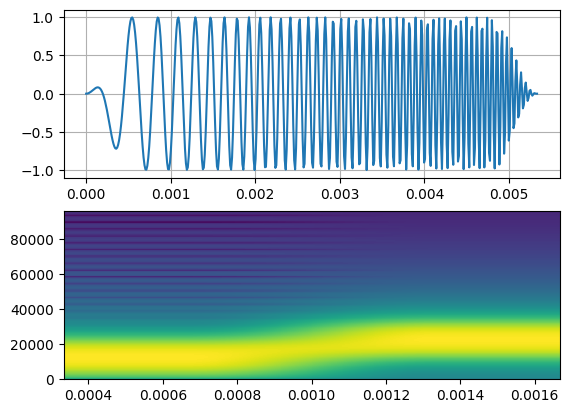

In [1]:
import sounddevice as sd
import numpy as np
import scipy.signal as signal
import time
from matplotlib import pyplot as plt

def get_soundcard_outstream(device_list):
    for i, each in enumerate(device_list):
        dev_name = each['name']
        asio_in_name = 'MCHStreamer' in dev_name
        if asio_in_name:
            return i

def pow_two_pad_and_window(vec, show = True):
    window = signal.windows.tukey(len(vec), alpha=0.2)
    windowed_vec = vec * window
    padded_windowed_vec = np.pad(windowed_vec, (0, 2**int(np.ceil(np.log2(len(windowed_vec)))) - len(windowed_vec)))
    if show:
        dur = len(padded_windowed_vec) / fs
        t = np.linspace(0, dur, len(windowed_vec))
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.grid()
        plt.plot(t, windowed_vec)
        plt.subplot(2, 1, 2)
        plt.specgram(windowed_vec, NFFT=256, Fs=192e3)
        plt.show()
    return padded_windowed_vec/max(padded_windowed_vec)

def pow_two(vec):
    return np.pad(vec, (0, 2**int(np.ceil(np.log2(len(vec)))) - len(vec)))

if __name__ == "__main__":

    fs = 96e3
    dur = 5e-3
    hi_freq =  1e3
    low_freq = 20e3
    n_sweeps = 5
    
    t_tone = np.linspace(0, dur, int(fs*dur))
    chirp = signal.chirp(t_tone, hi_freq, t_tone[-1], low_freq)
    sig = pow_two_pad_and_window(chirp, show=True)

    silence_dur = 30 # [ms]
    silence_samples = int(silence_dur * fs/1000)
    silence_vec = np.zeros((silence_samples, ))
    full_sig = pow_two(np.concatenate((sig, silence_vec)))
    stereo_sig = np.hstack([full_sig.reshape(-1, 1), full_sig.reshape(-1, 1)])

    output_sig = np.float32(stereo_sig)

3. The sweeps are recorded with Audacity through the mic and sound card listed above.

4. The Ro-Bat is rotated 10 \[deg\] counterclockwise, with the help of a goniometer printed on a sheet of paper and placed underneath, and steps 1-3 are repeated until the Ro-Bat is rotated 180 \[deg\] with respect to its starting position as in the image above.
Directivity is assumed symmetrical on the other side.

## Processing
1. Each recording is time gated around the first of the sweeps, since the first reflections don't overlap with the emitted signal. Signals are duplicated to cover 190 to 350 degrees range.

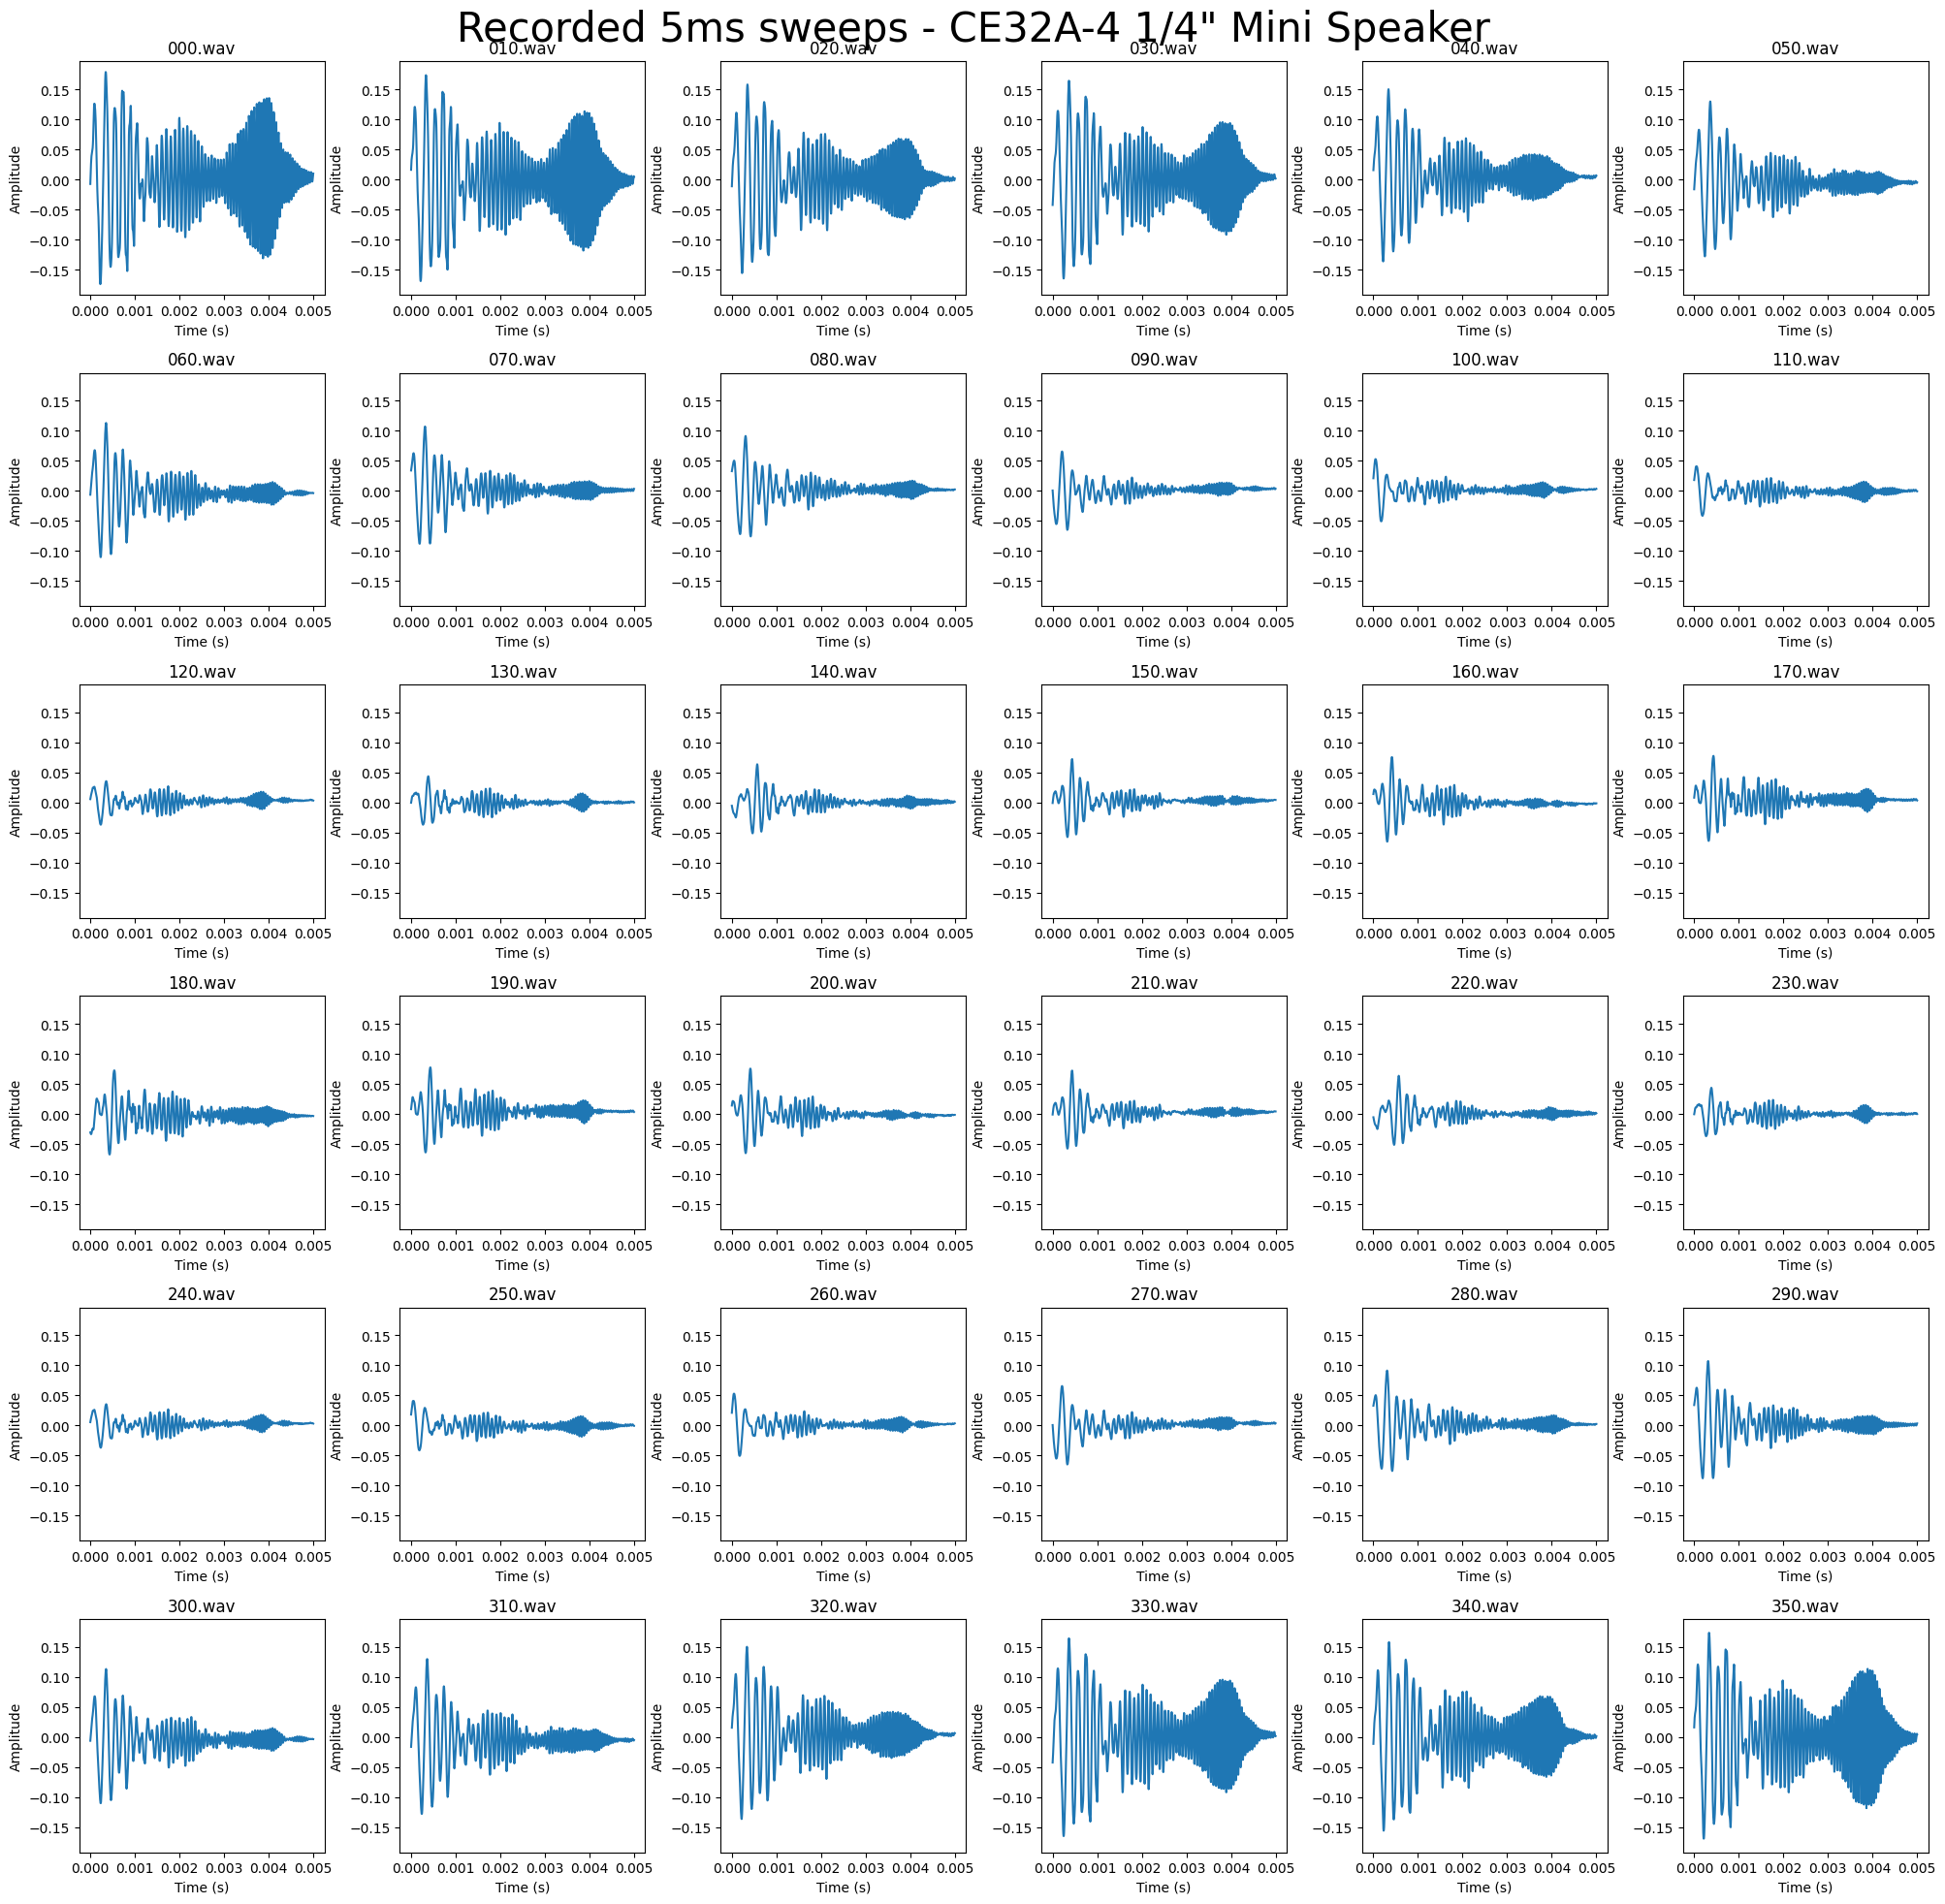

In [7]:
# %% Libraries and files

import os
import soundfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

# Load audio files, then plot them in a 6x6 grid
DIR = "./cut_sweeps/"  # Directory containing the audio files
audio_files = os.listdir(DIR)  # List all files in the sweeps directory
audio_files.sort()  # Sort the files in ascending order

# Load audio files, then plot them in a 6x6 grid
DIR_noise = "./noise_floor_5ms/"  # Directory containing the audio files
noise_files = os.listdir(DIR_noise)  # List all files in the sweeps directory
noise_files.sort()  # Sort the files in ascending order

# %% Plot of the collected data

fig, axs = plt.subplots(6, 6, figsize=(20, 20))

for i in range(6):
    for j in range(6):
        # Load audio file
        audio, fs = soundfile.read(DIR + audio_files[i * 6 + j])
        # Plot audio file
        axs[i, j].plot(np.linspace(0, len(audio) / fs, len(audio)), audio)
        axs[i, j].set_title(audio_files[i * 6 + j])
        axs[i, j].set_xlabel("Time (s)")
        axs[i, j].set_ylabel("Amplitude")
        # Shared x and y axes
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])

plt.suptitle("Recorded 5ms sweeps - CE32A-4 1/4\" Mini Speaker", fontsize=30)
plt.tight_layout()
plt.show(block=False)


2. From the isolated sweeps, the directivity pattern is computed for the whole spectrum of emission

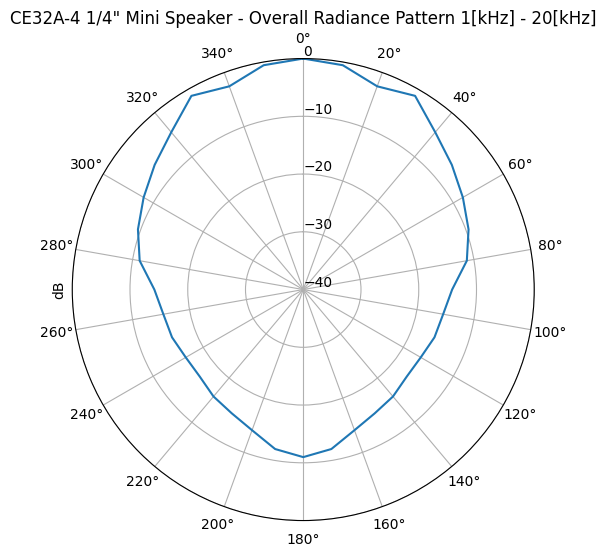

In [8]:
channels = []
for i in np.arange(len(audio_files)):
    audio, fs = soundfile.read(DIR + audio_files[i])
    # if audio.shape[0] > 1919:
    #     audio = audio[0:1919]
    channels.append(audio)
channels = np.array(channels)

Channels = fft.fft(channels, n=2048, axis=1)
#Channels_uni = Channels[:,0:1024] # Select the first half of the FFT
Channels_uni = Channels
freqs = fft.fftfreq(2048, 1 / fs) # Compute the frequency vector
#freqs = freqs[0:1024]# Select the first half of the frequency vector


R = 1 # Distance from the source in meters

radiance = 4 * np.pi * R * np.abs(Channels_uni) # Radiance computation
theta = np.linspace(0, 350, 36) # Angle vector
theta = np.append(theta, theta[0])

# %% Mean radiance pattern display

rad_patt = np.mean(radiance, axis=1)
rad_patt_norm = rad_patt / np.max(rad_patt)
rad_patt_norm_dB = 20 * np.log10(rad_patt_norm)
rad_patt_norm_dB = np.append(rad_patt_norm_dB, rad_patt_norm_dB[0])

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
ax.plot(np.deg2rad(theta), rad_patt_norm_dB)
# offset polar axes by -90 degrees
ax.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax.set_theta_direction(-1)
# more theta ticks
ax.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
ax.set_ylabel("dB")
# less radial ticks
ax.set_yticks(np.linspace(-40, 0, 5))
ax.set_rlabel_position(0)
ax.set_title("CE32A-4 1/4\" Mini Speaker - Overall Radiance Pattern 1[kHz] - 20[kHz]")
plt.show()

In [9]:
# Front-back radiance difference 
rad_patt_norm_dB[18]

-10.984247707814202

3. Directivity pattern in bands with additional calculation of the SNR values. 
Signal to Noise Ratio (SNR) is calculated by comparing the energy in each freq band between the signal and the corrresponding noise floor of 5 ms (in the same recording). 

REF: Havelock, David & Kuwano, Sonoko & Vorlaender, Michael. (2009). Handbook of Signal Processing in Acoustics. 10.1007/978-0-387-30441-0. PAGE 488


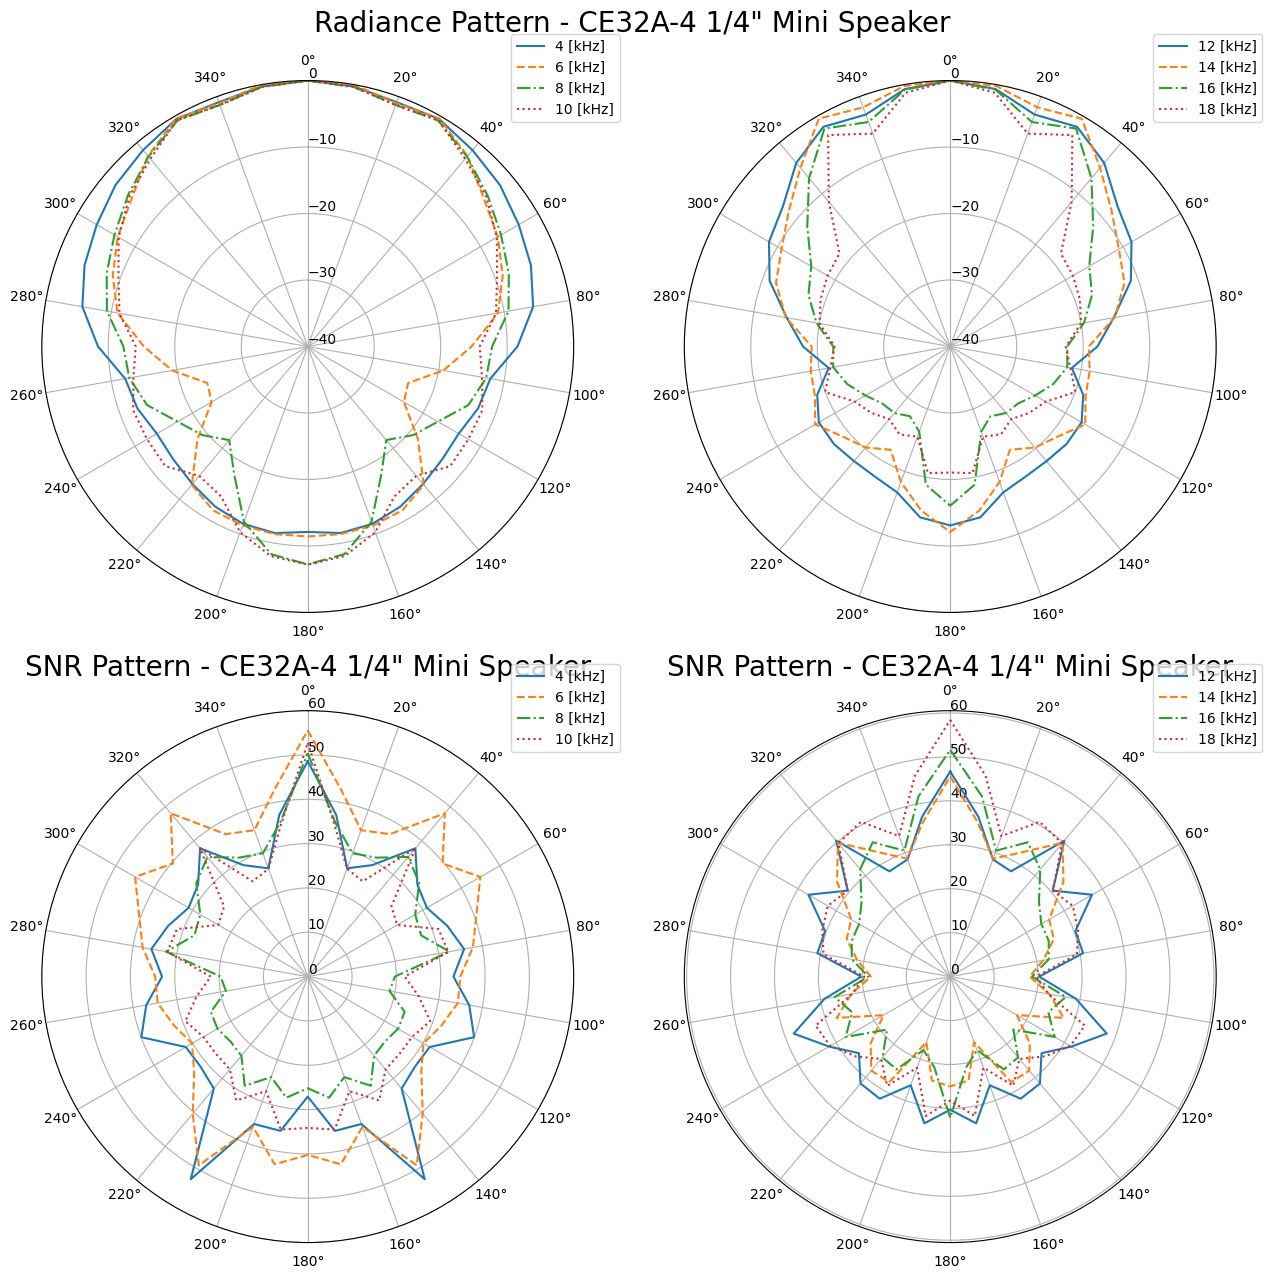

In [10]:
# %% SNR computation between the sweeps and the noise floor measurements for each freq band

def calculate_snr_bands(audio, noise):

    # Compute signal power (RMS value squared)
    P_signal = np.mean(audio**2)

    # extract noise power
    P_noise = np.mean(noise**2)

    # Compute SNR in dB
    SNR = 10 * np.log10(P_signal / P_noise)

    # Noise floor in dBFS (full scale)
    noise_floor = 10 * np.log10(P_noise)

    return SNR, noise_floor

noises = [] # Load noise files
for i in np.arange(len(noise_files)): 
    noise, fs = soundfile.read(DIR_noise + noise_files[i]) 
    noises.append(noise)
noises = np.array(noises)

NOISES = fft.fft(noises, n=2048, axis=1) # Compute the FFT of the noise files
# NOISES_uni = NOISES[:,0:1024] # Select the first half of the FFT
NOISES_uni = NOISES


# %% Radiance display at multiple frequencies

central_freq = np.array([4e3, 6e3, 8e3, 10e3, 12e3, 14e3, 16e3, 18e3]) # Central frequencies of the bands
BW = 1e3 # Bandwidth of the bands

linestyles = ["-", "--", "-.", ":"] # Line styles for the plot
# Create a figure and a set of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw={"projection": "polar"},figsize=(13, 13))
plt.suptitle("Radiance Pattern - CE32A-4 1/4\" Mini Speaker", fontsize=20)
i = 0

for fc in central_freq[0:4]:
    rad_patt = np.mean(
        radiance[:, (freqs < fc + BW) & (freqs > fc - BW)], axis=1
    ) # Compute the mean radiance in the band
    rad_patt_norm = rad_patt / np.max(rad_patt) # Normalize the radiance
    rad_patt_norm_dB = 20 * np.log10(rad_patt_norm) # Convert the radiance to dB
    rad_patt_norm_dB = np.append(rad_patt_norm_dB, rad_patt_norm_dB[0]) # Append the first value to the end of the vector

    snrs = []
    for ii in np.arange(len(Channels_uni)):
        snr_value, noise_floor_value = calculate_snr_bands(
                                Channels_uni[ii, (freqs < fc + BW) & (freqs > fc - BW)],    
                                NOISES_uni[ii, (freqs < fc + BW) & (freqs > fc - BW)]) # Compute the SNR in the band
        snrs.append(snr_value)
    snrs = np.array(snrs)
    snrs = np.append(snrs, snrs[0])

    # Plot the radiance pattern
    if str(fc)[0:2] == '10': # Display the frequency in kHz
        ax1.plot(
        np.deg2rad(theta),
        rad_patt_norm_dB,
        label=str(fc)[0:2] + " [kHz]",
        linestyle=linestyles[i],
        )
        ax3.plot(
        np.deg2rad(theta),
        snrs,
        label=str(fc)[0:2] + " [kHz]",
        linestyle=linestyles[i],
        )
    else:
        ax1.plot(
        np.deg2rad(theta),
        rad_patt_norm_dB,
        label=str(fc)[0:1] + " [kHz]",
        linestyle=linestyles[i],
        )
        ax3.plot(
        np.deg2rad(theta),
        snrs,
        label=str(fc)[0:1] + " [kHz]",
        linestyle=linestyles[i],
        )   
    i += 1

# Display the legend
ax1.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
# offset polar axes by -90 degrees
ax1.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax1.set_theta_direction(-1)
# more theta ticks
ax1.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
# less radial ticks
ax1.set_yticks(np.linspace(-40, 0, 5))
# Display the radial labels
ax1.set_rlabel_position(0)

ax3.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
# offset polar axes by -90 degrees
ax3.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax3.set_theta_direction(-1)
# more theta ticks
ax3.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
# less radial ticks
ax3.set_yticks(np.linspace(0, 60, 7))
ax3.set_rlabel_position(0)

i = 0
for fc in central_freq[4:8]:
    rad_patt = np.mean(
        radiance[:, (freqs < fc + BW) & (freqs > fc - BW)], axis=1
    )
    noise_patt = np.mean(
        NOISES_uni[:, (freqs < fc + BW) & (freqs > fc - BW)], axis=1
    )
    rad_patt_norm = rad_patt / np.max(rad_patt)
    rad_patt_norm_dB = 20 * np.log10(rad_patt_norm)
    rad_patt_norm_dB = np.append(rad_patt_norm_dB, rad_patt_norm_dB[0])
    
    snrs = []
    for ii in np.arange(len(Channels_uni)):
        #Channels_uni = np.abs(Channels_uni) #moved outside the loop
        snr_value, noise_floor_value = calculate_snr_bands(Channels_uni[ii, (freqs < fc + BW) & (freqs > fc - BW)]    
                                 , NOISES_uni[ii, (freqs < fc + BW) & (freqs > fc - BW)])
        snrs.append(snr_value)
    snrs = np.array(snrs)
    snrs = np.append(snrs, snrs[0])

    ax2.plot(
        np.deg2rad(theta),
        rad_patt_norm_dB,
        label=str(fc)[0:2] + " [kHz]",
        linestyle=linestyles[i],
    )
    ax4.plot(
        np.deg2rad(theta),
        snrs,
        label=str(fc)[0:2] + " [kHz]",
        linestyle=linestyles[i],
        )
    i += 1
ax2.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
# offset polar axes by -90 degrees
ax2.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax2.set_theta_direction(-1)
# more theta ticks
ax2.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
# less radial ticks
ax2.set_yticks(np.linspace(-40, 0, 5))
ax2.set_rlabel_position(0)

ax4.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
# offset polar axes by -90 degrees
ax4.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax4.set_theta_direction(-1)
# more theta ticks
ax4.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
# less radial ticks
ax4.set_yticks(np.linspace(0, 60, 7))
ax4.set_rlabel_position(0)
ax4.set_title("SNR Pattern - CE32A-4 1/4\" Mini Speaker", fontsize=20)
ax3.set_title("SNR Pattern - CE32A-4 1/4\" Mini Speaker", fontsize=20)

plt.tight_layout()
plt.show()

4. Check of the noise floor recordings for each angle.
(Again values from 190 to 350 are only repetitions)

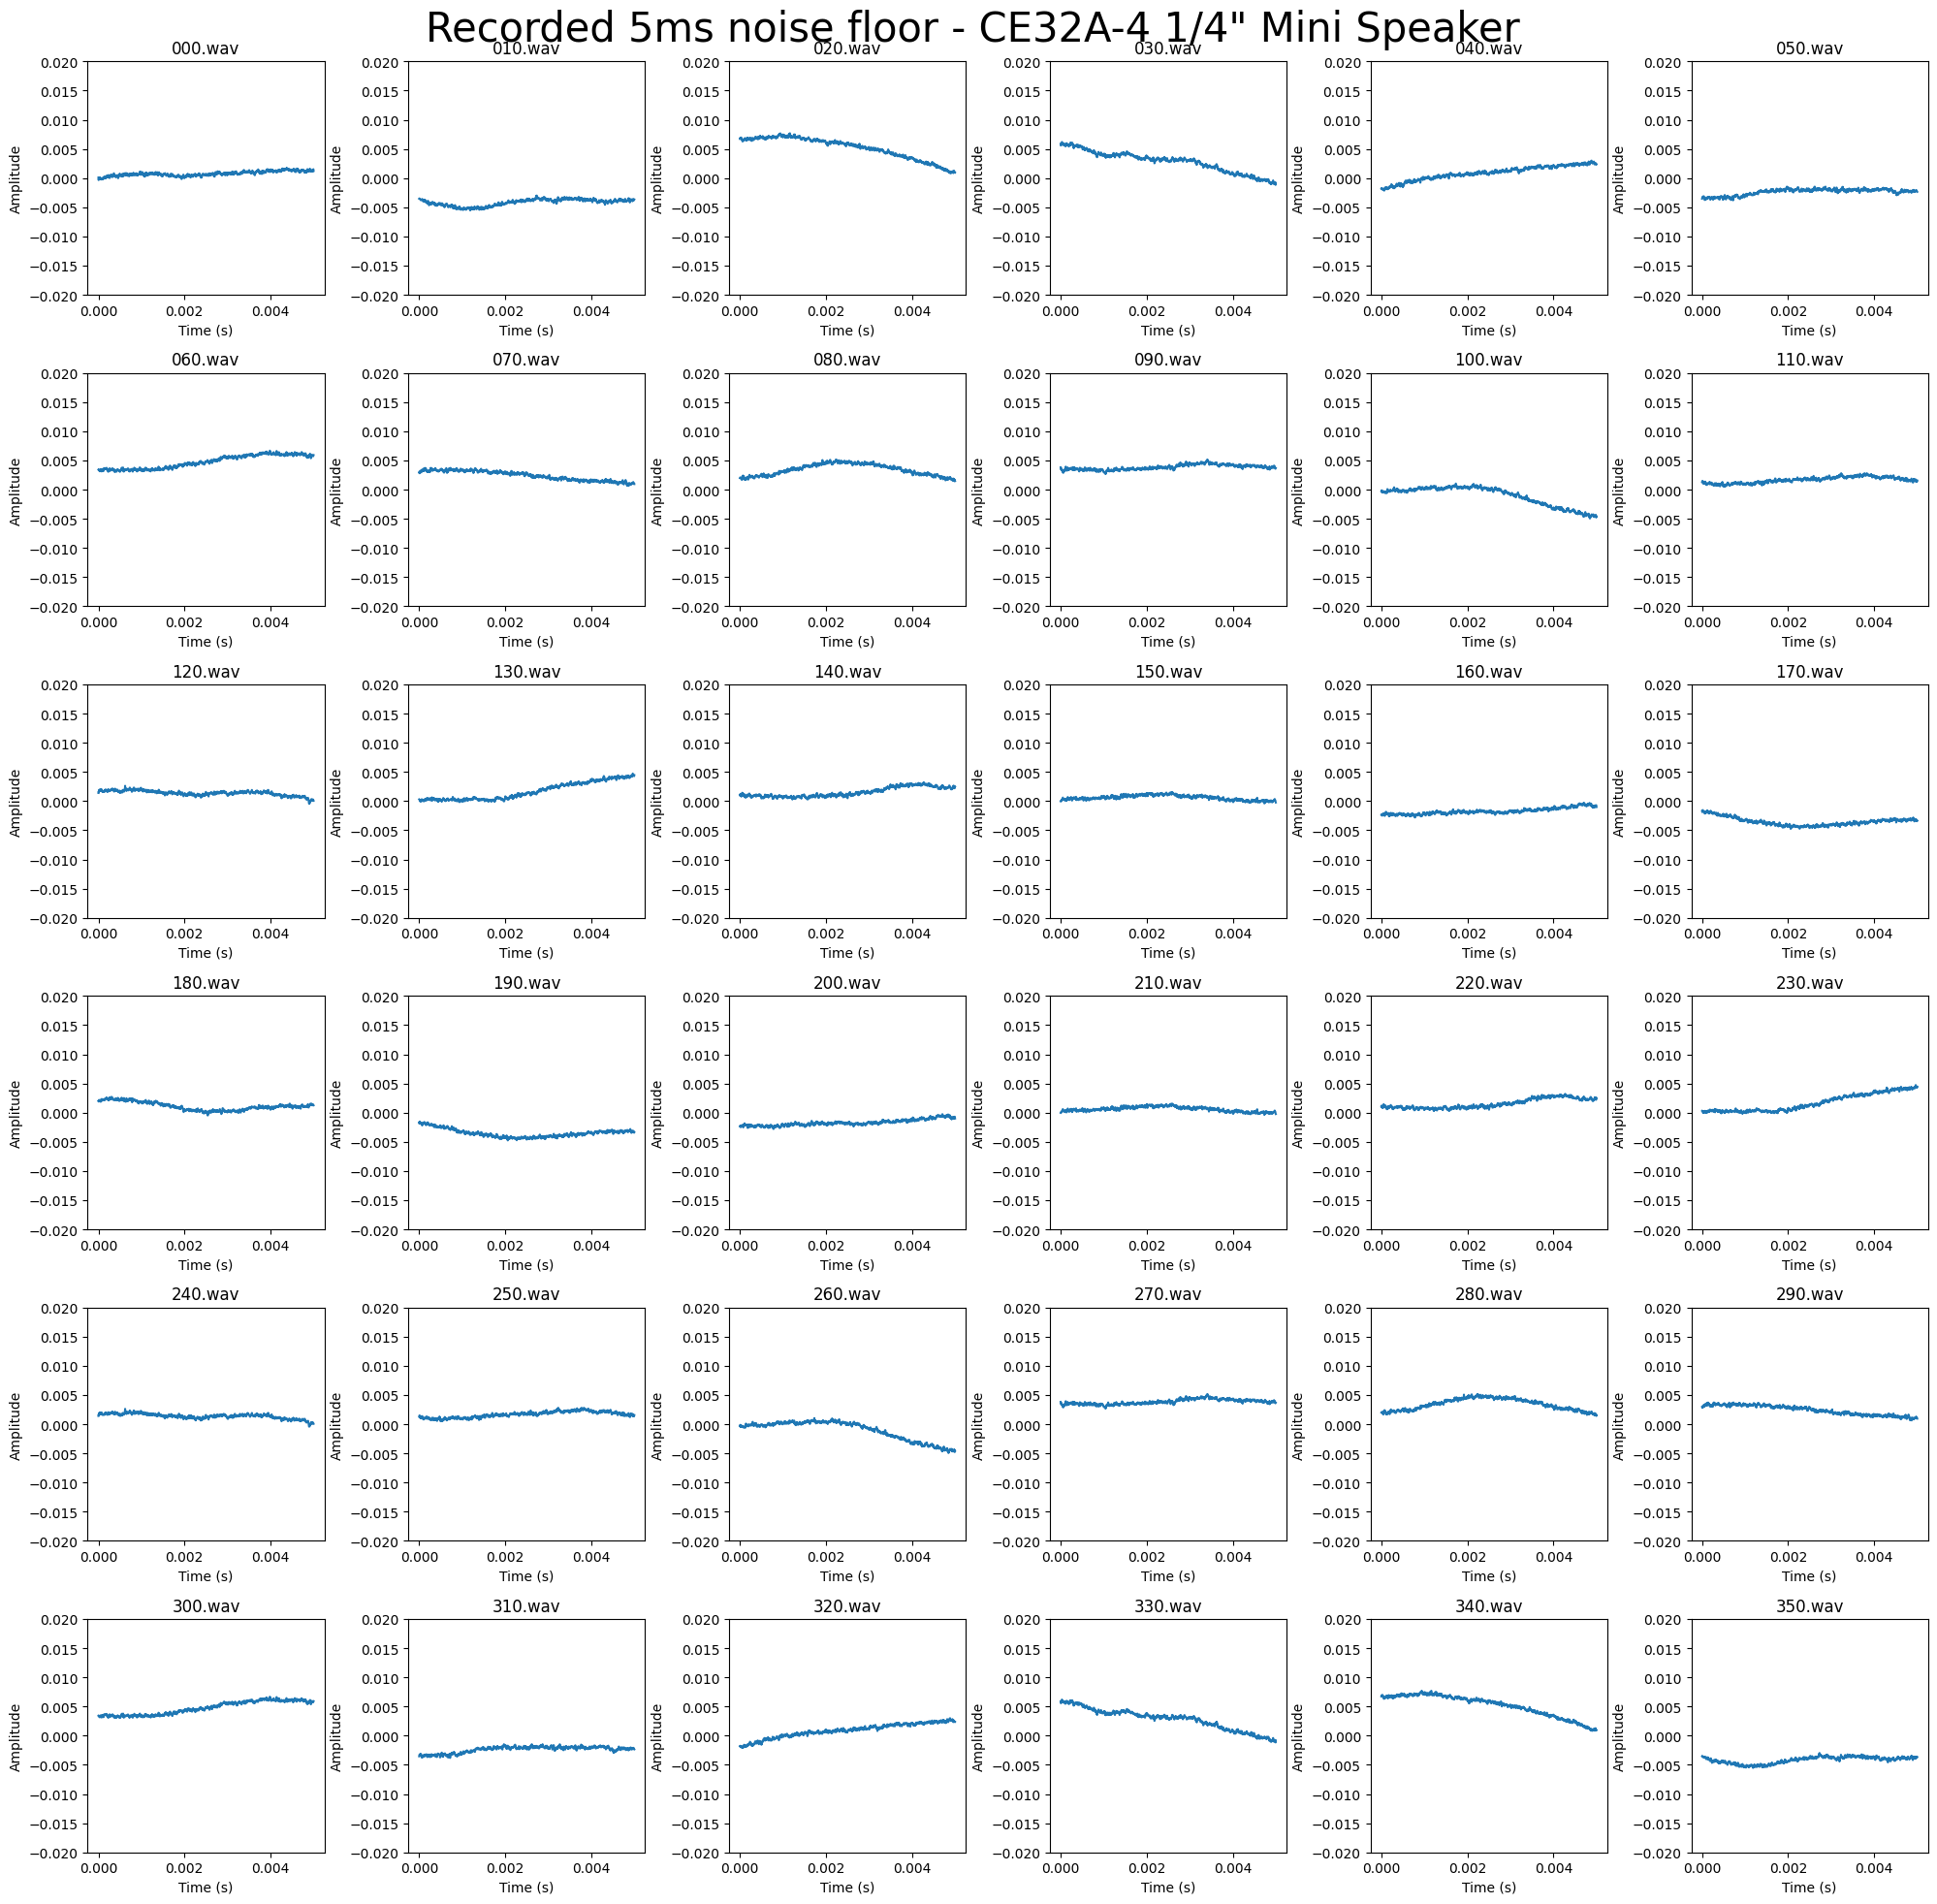

In [13]:
# %% Plot of the noise data

fig, axs = plt.subplots(6, 6, figsize=(20, 20))

for i in range(6):
    for j in range(6):
        # Load audio file
        audio, fs = soundfile.read(DIR_noise + audio_files[i * 6 + j])
        # Plot audio file
        axs[i, j].plot(np.linspace(0, len(audio) / fs, len(audio)), audio)
        axs[i, j].set_title(audio_files[i * 6 + j])
        axs[i, j].set_xlabel("Time (s)")
        axs[i, j].set_ylabel("Amplitude")
        # ylim for better visualization
        axs[i, j].set_ylim([-0.02, 0.02])
        # Shared x and y axes
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])

plt.suptitle("Recorded 5ms noise floor - CE32A-4 1/4\" Mini Speaker", fontsize=30)
plt.tight_layout()
plt.show(block=False)

5. Overall SNR from all the bands over a 5ms noise signal from the recordings

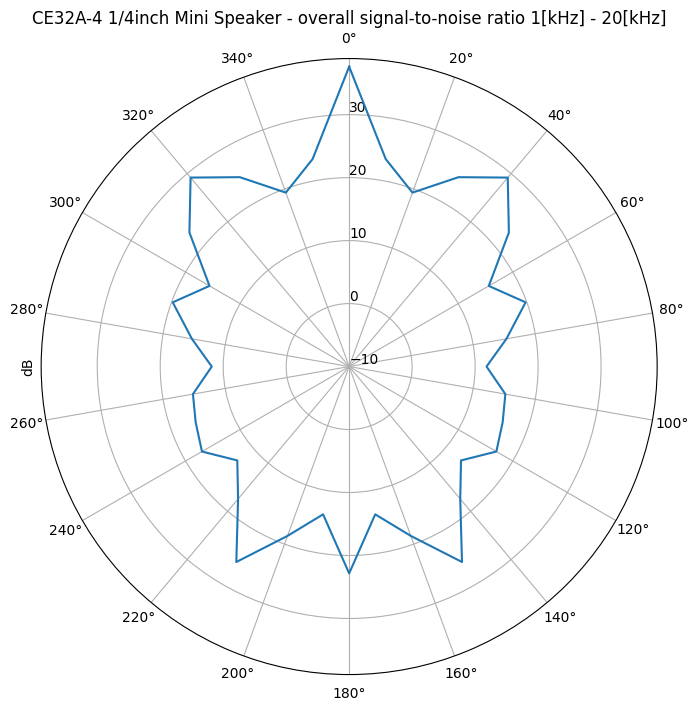

In [14]:
#%% overall SNR computation

def calculate_snr(audio, noise):

    # Compute signal power (RMS value squared)
    P_signal = np.mean(audio**2)

    # If noise segment is provided, extract noise power
    P_noise = np.mean(noise**2)

    # Compute SNR in dB
    SNR = 10 * np.log10(P_signal / P_noise)

    # Noise floor in dBFS (full scale)
    noise_floor = 10 * np.log10(P_noise)

    return SNR, noise_floor

snrs = []
for i in np.arange(len(channels)):
    snr_value, noise_floor_value = calculate_snr(channels[i], noises[i])
    snrs.append(snr_value)
snrs = np.array(snrs)
snrs = np.append(snrs, snrs[0])

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 8))
ax.plot(np.deg2rad(theta), snrs)
# offset polar axes by -90 degrees
ax.set_theta_offset(np.pi / 2)
# set theta direction to clockwise
ax.set_theta_direction(-1)
# more theta ticks
ax.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))
ax.set_ylabel("dB")
# less radial ticks
ax.set_yticks(np.linspace(-10, 30, 5))
ax.set_rlabel_position(0)
ax.set_title("CE32A-4 1/4inch Mini Speaker - overall signal-to-noise ratio 1[kHz] - 20[kHz]")

plt.show()
#save figure
fig.savefig("./figures/snr_overall.png")


## Conclusions
- **Recorded signals** seem to be somehow filtered with respect to the generated sweep, showing inconsistent amplitude, maybe caused by the loudspeaker itself or the DAC used for the signal output.  
- There is a **dropoff** of about -10.98 \[dB\] **front-to-back** radiance difference.
- **Radiance pattern** with bands looks realistic and becomes more directive going towards high frequencies, however some frequncy bands like 6 and 8 Khz don't strictly follow this trend since they are thinner than 10 Khz band.
- **SNR calculation in bands** looks strangely high with respect to the overall counterpart, which matches approximately the naives calculations made in audacity (with the *contrast* tool).